## 自己符号化器（Auntoencoder）

ここでは、Kerasを用いて、自己符号化器の学習を行う。  
[参考]  
https://blog.keras.io/building-autoencoders-in-keras.html

In [2]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

Using TensorFlow backend.


### MNISTデータの読み込み

In [3]:
# Load the MNIST dataset
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(X_train, y_train),(X_test, y_test) = mnist.load_data()

# 28*28の画像データを784のベクトルに変換する
X_train = X_train.reshape(-1, 784) / 255
X_test = X_test.reshape(-1, 784) / 255

### モデルの定義
モデルは入力層-中間層-出力層の構成とする。  
入力層-中間層がエンコーダ、中間層-出力層がデコーダになる。  
なお、ここでは、ノードの集まり層と呼んでいる。  

In [4]:
# 中間層のノード数
encoding_dim = 36

# 入力層の定義
input_img = Input(shape=(784,)) 

# 入力層〜中間層を定義
encoded = Dense(encoding_dim, activation='relu')(input_img)

# 中間層〜出力層を定義
decoded = Dense(784, activation='sigmoid')(encoded)
# decoded = Dense(784, activation='linear')(encoded)
 
# 入力層〜中間層までをつなげて、ネットワークを完成させる
autoencoder = Model(inputs=input_img, outputs=decoded)

# 損失関数と最適化手法の定義
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
# autoencoder.compile(optimizer='adam', loss="mean_squared_error") 


# 計算結果を利用しやすくするために、以下のモデルを定義

# エンコーダ部分だけのモデルを定義
encoder = Model(inputs=input_img, outputs=encoded)

# デコーダ部分だけのモデルを定義
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1] # 中間層〜出力層
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

W0421 14:08:21.637796 4398298560 deprecation_wrapper.py:119] From /Users/ogata/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0421 14:08:21.697993 4398298560 deprecation_wrapper.py:119] From /Users/ogata/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0421 14:08:21.725054 4398298560 deprecation_wrapper.py:119] From /Users/ogata/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0421 14:08:21.775340 4398298560 deprecation_wrapper.py:119] From /Users/ogata/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimiz

### 自己符号化器の訓練
自己符号化器を訓練する。入力データと正解データに同じデータを用いる。

W0421 14:08:22.175860 4398298560 deprecation_wrapper.py:119] From /Users/ogata/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 79us/step - loss: 0.2704 - val_loss: 0.1828
Epoch 2/20
60000/60000 [==============================] - 5s 83us/step - loss: 0.1653 - val_loss: 0.1492
Epoch 3/20
60000/60000 [==============================] - 6s 105us/step - loss: 0.1405 - val_loss: 0.1300
Epoch 4/20
60000/60000 [==============================] - 6s 106us/step - loss: 0.1249 - val_loss: 0.1178
Epoch 5/20
60000/60000 [==============================] - 7s 110us/step - loss: 0.1145 - val_loss: 0.1084
Epoch 6/20
60000/60000 [==============================] - 8s 136us/step - loss: 0.1063 - val_loss: 0.1020
Epoch 7/20
60000/60000 [==============================] - 8s 137us/step - loss: 0.1010 - val_loss: 0.0976
Epoch 8/20
60000/60000 [==============================] - 8s 139us/step - loss: 0.0972 - val_loss: 0.0945
Epoch 9/20
60000/60000 [==============================] - 8s 140us/step - loss: 0.0946 - val_loss: 0.092

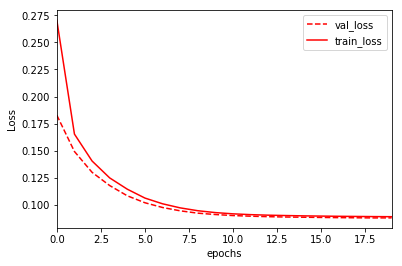

In [5]:
history = autoencoder.fit(X_train, X_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))

# 計算過程の描画
df_log = pd.DataFrame(history.history)
df_log.rename(columns={"loss":"train_loss"}, inplace=True)
df_log.plot(style=['r--', 'r-'])
plt.ylabel("Loss")
plt.xlabel("epochs")
plt.show()

### テストデータを入力し、中間層と出力層の値を得る
encoderとdecoderはautoencoderと連動しているので、中間層と出力層の値を個別に得ることができる。

In [6]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)
# decoded_imgs = autoencoder.predict(X_test) #としても同じ

### 結果の可視化
matplotlibを使って結果を可視化する。

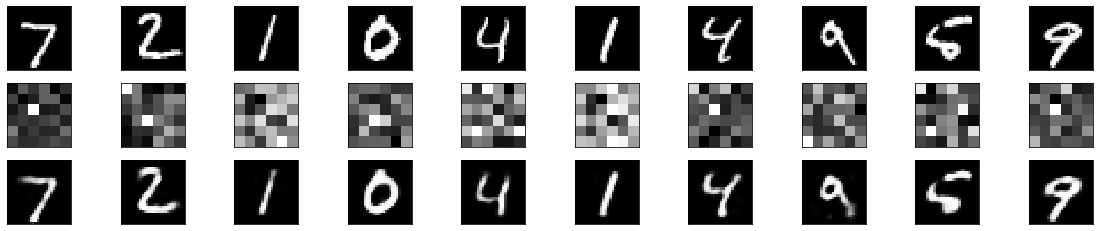

In [7]:
# 表示させる画像の枚数
n = 10  

plt.figure(figsize=(20, 4))
for i in range(n):
    # 元画像
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 中間層の出力値
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(6,6)) #画像サイズは、encoding_dimに合わせて変更する
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # 出力層の出力値(復元画像)
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### [演習]
* Epoch数を減らすと再構成画像がどうなるか確認してみましょう。
* 中間層のノード数を減らすと再構成画像がどうなるか確認してみましょう。
* 通し課題における自己符号化器の活用方法を考えてみましょう。